<a href="https://colab.research.google.com/github/AyberkMunis/IELTS_Score_Prediction_From_Writing/blob/main/IELTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting IELTS Scores from writting passages by both Regression and Classification Perspective**

#Business Problem

* IELTS is a standard English Level test which has 4 main parts (Listening, Reading,Writing and Speaking). The scores are scaled between 1 and 9. This project's main goal is developing a NLP model to predict IELTS scores from candidate's writing passages. First, a classification model would be used for predicting, then same problem will be tried to solve by using regression models.

# Steps of the Project

0. Importing Libraries and Needed Functions
1. Importing Data and Preprocessing
2. Classification Model
3. Regression Model
4. Conclusion


# 0.Importing Libraries and Needed Functions

In [1]:
!pip install opendatasets


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import opendatasets as od
from scipy.stats import pearsonr
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow_hub as tfh
import math

In [3]:
def removepunc(data):
  for i in punctuation:
    if i==".":
      data=data.replace(i," ")
    else:
      data=data.replace(i,"")
  data=data.replace("\n","")

  return data

In [4]:
def masknum(data):
  data=removepunc(data)
  words=data.split(" ")
  for k,i in enumerate(words):
    if i.isnumeric():
      words[k]="@"
  return " ".join(words)


In [5]:
def vocab(data):
  vocab=[]
  for i in data:
    words=i.split(" ")
    for x in words:
      vocab.append(x.lower())
  return set(vocab)


In [6]:
def standard(data):
  data=StandardScaler().fit_transform(data)
  return data

In [7]:
def roundielts(x):
  if  (x*10)%10 >2.5 and  x*10%10 <5:
    return math.floor(x) + 0.5
  elif x*10%10 >5:
    return math.ceil(x)
  else:
    return math.floor(x)

In [8]:
!pip install opendatasets

#1. Importing Data and Preprocessing

In [9]:
od.download("https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ayberkmunis
Your Kaggle Key: ··········


100%|██████████| 674k/674k [00:00<00:00, 1.48MB/s]

In [10]:
data=pd.read_csv("/content/ielts-writing-scored-essays-dataset/ielts_writing_dataset.csv")
data.head()

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,NaN,NaN,NaN,NaN,5.0
3,2,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,NaN,NaN,NaN,NaN,NaN,5.5
4,1,The graph below shows the number of overseas v...,Information about the thousands of visits from...,NaN,NaN,NaN,NaN,NaN,7.0


In [11]:
classnum=len(data["Overall"].unique())
classnum

14

In [12]:
data.groupby("Task_Type").agg({"Task_Type":"count"})

,Task_Type
Task_Type,
1,642
2,793


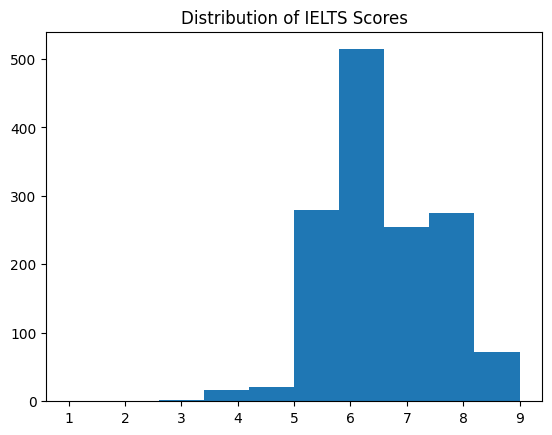

In [13]:
plt.hist(data["Overall"])
plt.title("Distribution of IELTS Scores")
plt.show()

In [14]:
data.groupby("Overall").agg({"Overall":"count"}) #This dataset is an unbalanced set.

,Overall
Overall,
1.0,1
3.0,2
3.5,5
4.0,11
4.5,21
5.0,104
5.5,176
6.0,264
6.5,250


In [15]:
# Now we will add length of writing essay as Feature Engineering
data["length"]=data["Essay"].apply(lambda x: len(x.split(" ")))


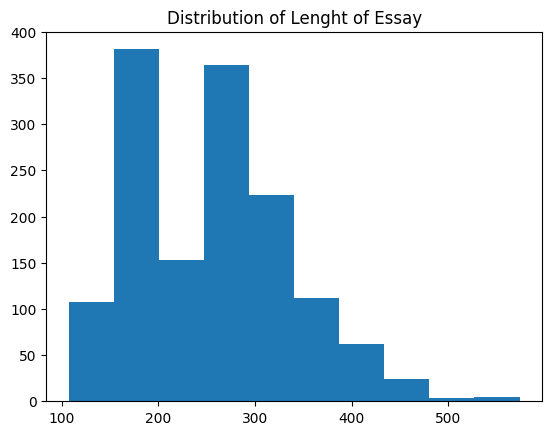

In [16]:
plt.hist(data["length"])
plt.title("Distribution of Lenght of Essay")
plt.show()

In [17]:
#We will investigate correlation between length and scores

data.groupby(["Overall"]).agg({"length":"mean"}) # Essays that longer than 258 words got at least 7, it seems a correlation between score and length

,length
Overall,
1.0,277.000000
3.0,192.500000
3.5,137.200000
4.0,211.636364
4.5,217.619048
5.0,231.509615
5.5,226.011364
6.0,246.022727
6.5,245.872000


In [18]:
data2=data.copy()

In [19]:
data2["text"]=data2["Essay"].apply(masknum) #We are masking the numerical values and removing punctuation

In [20]:
data2["text"][4]

'Information about the thousands of visits from overseas to three different European natural places during @ and @ is provided in the given line chart Overall it can be seen that the number of visitors increased significantly in the three places compared to the initial year  Although visits to Europeans lakes demostrated more changes over the @ years than its counterparts In more detail the most steady growth was experienced by the visits to Europeans mountains  For example from @ the number of visitors grew from @ to almost the double @ years later  Similarly visits to the coast also rose after a slight fall in @ reaching almost twice as much since @ with @ Those visiting Europeans lakes subtantially increased over the years from @ thousand to a peak of @ thousand in @  Despite falling for about @ thousand in @ the visitis to this place remained higher compared to @ with @ at the end of the period '

In [21]:
data2["Overall2"]=data2["Overall"].apply(lambda x: str(x))

In [22]:
X=data2[["text","Task_Type"]]
y=data2["Overall2"]

In [23]:
X

,text,Task_Type
0,Between @ and @ a study was conducted represen...,1
1,Poverty represents a worldwide crisis It is t...,2
2,The left chart shows the population change hap...,1
3,Human beings are facing many challenges nowada...,2
4,Information about the thousands of visits from...,1
...,...,...
1430,Serious crimes need capital punishment so that...,2
1431,It is certainly said that learning is an ongoi...,2
1432,popular hobbies rather than their individual a...,2
1433,Yes I do feel that universities should have an...,2


In [ ]:
cats=y.unique()

In [ ]:
cats

array(['5.5', '6.5', '5.0', '7.0', '8.0', '9.0', '6.0', '8.5', '7.5',
       '3.5', '4.5', '4.0', '3.0', '1.0'], dtype=object)

In [24]:
oe=OrdinalEncoder()

In [25]:
y

0       5.5
1       6.5
2       5.0
3       5.5
4       7.0
       ... 
1430    5.0
1431    5.0
1432    5.0
1433    5.0
1434    5.0
Name: Overall2, Length: 1435, dtype: object

In [26]:
y2=oe.fit_transform(np.array(y)[:,np.newaxis])

In [27]:
oe.categories_

[array(['1.0', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5',
        '7.0', '7.5', '8.0', '8.5', '9.0'], dtype=object)]

In [28]:
y2

array([[6.],
       [8.],
       [5.],
       ...,
       [5.],
       [5.],
       [5.]])

In [29]:
y3=tf.keras.utils.to_categorical(y2,num_classes=classnum)

In [ ]:
y3[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y3,random_state=42,test_size=0.2) #Because of size of the data set, 10% of test set will be used as validation set

In [31]:
max_vocab_length=len(vocab(data2["text"]))
max_vocab_length

14696

In [32]:
max_length=int(np.percentile(data2["length"],96))
max_length

410

In [50]:
vectorizer=tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,output_sequence_length=max_length,standardize='lower_and_strip_punctuation')


In [51]:
vectorizer.adapt(X_train["text"])

In [ ]:
len(vectorizer.get_vocabulary())

13304

In [ ]:
embedding=tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),output_dim=128,mask_zero=True)

#2. Classification Models

In [37]:
def createmlp():
  model=tf.keras.Sequential([
      tf.keras.layers.Dense(32,activation="relu",input_shape=(1,)),
      tf.keras.layers.Dense(16,activation="relu")

  ])
  return model

In [38]:
def createuse():
  sentence_encode_layer=tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)
  sentence_inputs=tf.keras.layers.Input(shape=[],dtype="string")
  sentence_=sentence_encode_layer(sentence_inputs)
  sentence_=tf.keras.layers.Dense(16,activation="relu")(sentence_)
  sentence_output=tf.keras.layers.Dropout(0.5)(sentence_)
  sentence_model=tf.keras.Model(sentence_inputs,sentence_output)

  return sentence_model

In [73]:
mlp=createmlp()
rnn=createuse()
combinedInput = tf.keras.layers.concatenate([mlp.output, rnn.output])
x=tf.keras.layers.Dense(32,activation="relu")(combinedInput)
outputs=tf.keras.layers.Dense(14,activation="softmax",name="outputs")(x)
modelhybridclass=tf.keras.Model(inputs=[mlp.input,rnn.input],outputs=outputs,name="HybridClassificationModel")

In [47]:
modelhybridclass.summary()

Model: "HybridClassificationModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 dense_6_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  (None, 512)                  2567978   ['input_2[0][0]']             
                                                          24                                      
                                                                                                  
 dense_6 (Dense)             (None, 32)                   64        ['dens

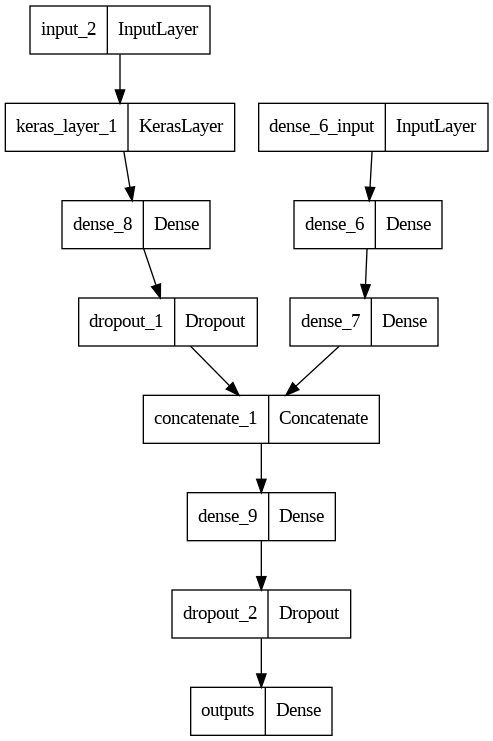

In [48]:
#Our model will have text and task type as input (because different tasks are evaluted differently)
tf.keras.utils.plot_model(modelhybridclass)

In [65]:
es=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)

In [74]:
modelhybridclass.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [75]:
historyhybridclass=modelhybridclass.fit(x=[X_train["Task_Type"],X_train["text"]],epochs=150,y=y_train,validation_data=([X_test["Task_Type"],X_test["text"]],y_test),validation_steps=len(y_test))

Epoch 1/150
36/36 [==============================] - 6s 81ms/step - loss: 2.5548 - accuracy: 0.1742 - val_loss: 2.4373 - val_accuracy: 0.1847
Epoch 2/150
36/36 [==============================] - 2s 68ms/step - loss: 2.3391 - accuracy: 0.1838 - val_loss: 2.2176 - val_accuracy: 0.1986
Epoch 3/150
36/36 [==============================] - 2s 70ms/step - loss: 2.2064 - accuracy: 0.2125 - val_loss: 2.1540 - val_accuracy: 0.2056
Epoch 4/150
36/36 [==============================] - 2s 69ms/step - loss: 2.1707 - accuracy: 0.1969 - val_loss: 2.1355 - val_accuracy: 0.2056
Epoch 5/150
36/36 [==============================] - 2s 68ms/step - loss: 2.1459 - accuracy: 0.2082 - val_loss: 2.1277 - val_accuracy: 0.2056
Epoch 6/150
36/36 [==============================] - 2s 67ms/step - loss: 2.1253 - accuracy: 0.2047 - val_loss: 2.1198 - val_accuracy: 0.1951
Epoch 7/150
36/36 [==============================] - 2s 68ms/step - loss: 2.1241 - accuracy: 0.1943 - val_loss: 2.1064 - val_accuracy: 0.2021
Epoch 

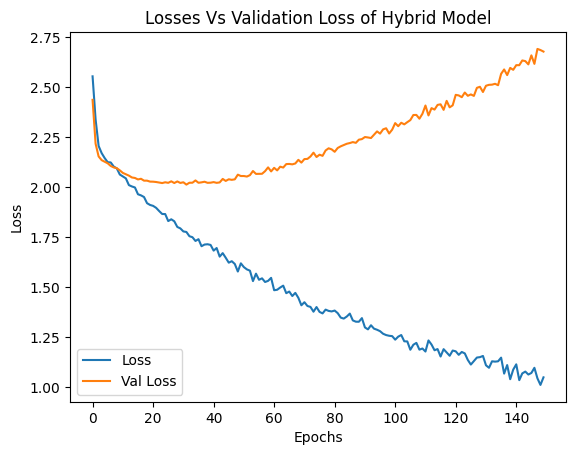

In [76]:
plt.plot(historyhybridclass.history["loss"])
plt.plot(historyhybridclass.history["val_loss"])
plt.title("Losses Vs Validation Loss of Hybrid Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In [78]:
#This model will take only the text as input
input=tf.keras.layers.Input(shape=[],name="Input",dtype="string")
x=vectorizer(input)
x=embedding(x)
x=tf.keras.layers.LSTM(64)(x)
outputs=tf.keras.layers.Dense(14,activation="softmax",name="output")(x)
modelrnnclass=tf.keras.Model(input,outputs,name="RNNClassificationModel")

In [79]:
modelrnnclass.summary()

Model: "RNNClassificationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None,)]                 0         
                                                                 
 text_vectorization (TextVe  (None, 410)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 410, 128)          1702912   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 output (Dense)              (None, 14)                910       
                                                                 
Total params: 1753230 (6.69 MB)
Trainable params: 1753230 (6.69 MB)
Non-trainable params: 0 (0.00 Byte)
______

In [80]:
modelrnnclass.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [81]:
historyrnnclass=modelrnnclass.fit(X_train["text"],epochs=150,y=y_train,validation_data=(X_test["text"],y_test))

Epoch 1/150
36/36 [==============================] - 14s 246ms/step - loss: 2.4159 - accuracy: 0.1760 - val_loss: 2.1451 - val_accuracy: 0.1777
Epoch 2/150
36/36 [==============================] - 7s 185ms/step - loss: 2.1459 - accuracy: 0.1951 - val_loss: 2.1108 - val_accuracy: 0.1986
Epoch 3/150
36/36 [==============================] - 6s 170ms/step - loss: 2.0815 - accuracy: 0.3127 - val_loss: 2.0671 - val_accuracy: 0.2195
Epoch 4/150
36/36 [==============================] - 6s 178ms/step - loss: 1.8171 - accuracy: 0.4251 - val_loss: 2.0221 - val_accuracy: 0.2578
Epoch 5/150
36/36 [==============================] - 6s 165ms/step - loss: 1.3257 - accuracy: 0.6193 - val_loss: 2.1563 - val_accuracy: 0.2718
Epoch 6/150
36/36 [==============================] - 5s 149ms/step - loss: 0.8537 - accuracy: 0.7840 - val_loss: 2.1832 - val_accuracy: 0.2962
Epoch 7/150
36/36 [==============================] - 5s 131ms/step - loss: 0.5136 - accuracy: 0.8807 - val_loss: 2.4191 - val_accuracy: 0.310

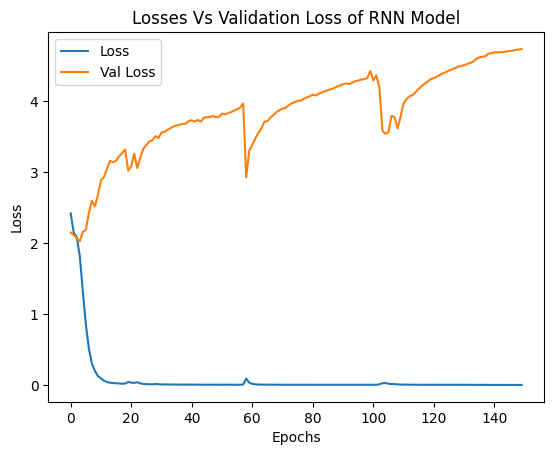

In [82]:
plt.plot(historyrnnclass.history["loss"])
plt.plot(historyrnnclass.history["val_loss"])
plt.title("Losses Vs Validation Loss of RNN Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In [83]:

sentence_encode_layer=tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",input_shape=[],dtype=tf.string,trainable=False)
input=tf.keras.layers.Input(shape=[],name="Input",dtype="string")
x=sentence_encode_layer(input)
x=tf.keras.layers.Dense(64,activation="relu")(x)
outputs=tf.keras.layers.Dense(14,activation="softmax",name="output")(x)
modelpreclass=tf.keras.Model(input,outputs,name="PreClassificationModel")

In [84]:
modelpreclass.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [85]:
historypreclass=modelpreclass.fit(X_train["text"],epochs=150,y=y_train,validation_data=(X_test["text"],y_test))

Epoch 1/150
36/36 [==============================] - 4s 39ms/step - loss: 2.5186 - accuracy: 0.1882 - val_loss: 2.3611 - val_accuracy: 0.1986
Epoch 2/150
36/36 [==============================] - 1s 26ms/step - loss: 2.2340 - accuracy: 0.2213 - val_loss: 2.1524 - val_accuracy: 0.2021
Epoch 3/150
36/36 [==============================] - 1s 27ms/step - loss: 2.0995 - accuracy: 0.2605 - val_loss: 2.1039 - val_accuracy: 0.2056
Epoch 4/150
36/36 [==============================] - 1s 26ms/step - loss: 2.0441 - accuracy: 0.2700 - val_loss: 2.0867 - val_accuracy: 0.2509
Epoch 5/150
36/36 [==============================] - 1s 29ms/step - loss: 1.9996 - accuracy: 0.3049 - val_loss: 2.0750 - val_accuracy: 0.2474
Epoch 6/150
36/36 [==============================] - 1s 28ms/step - loss: 1.9573 - accuracy: 0.3301 - val_loss: 2.0699 - val_accuracy: 0.2265
Epoch 7/150
36/36 [==============================] - 1s 28ms/step - loss: 1.9156 - accuracy: 0.3449 - val_loss: 2.0602 - val_accuracy: 0.2265
Epoch 

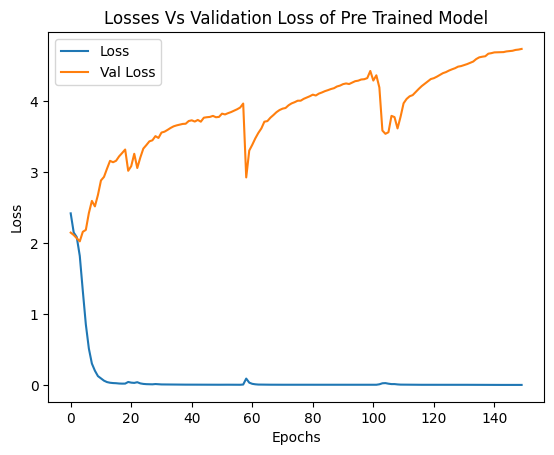

In [86]:
plt.plot(historyrnnclass.history["loss"])
plt.plot(historyrnnclass.history["val_loss"])
plt.title("Losses Vs Validation Loss of Pre Trained Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In teh end, all of the models are overfitted which concludes defining this problem as classification is not useful. The reason behind overfitting could be using unbalanced data. To resolve unbalanced data problem undersampling or rare encoding could be used, however some classes have very small amount of data and using rare encoding could lose some classes ordinality. Therefore, we would try same problem by defining it as Regression.




#3. Regression Models

In [33]:
y2=data2["Overall"].astype("float32")

In [134]:
X_train,X_test,y_train,y_test=train_test_split(X,y2,random_state=42,test_size=0.2)

In [35]:
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5)

In [39]:
#Model with inptus task type and text (uses USE)
mlp=createmlp()
rnn=createuse()
combinedInput = tf.keras.layers.concatenate([mlp.output, rnn.output])
x=tf.keras.layers.Dense(32,activation="relu")(combinedInput)
outputs=tf.keras.layers.Dense(1,activation="linear",name="outputs")(x)
modelhybridreg=tf.keras.Model(inputs=[mlp.input,rnn.input],outputs=outputs,name="HybridRegressionModel")

In [40]:
modelhybridreg.compile(loss=tf.keras.losses.mean_squared_error,optimizer=tf.keras.optimizers.Adam(0.001),metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [41]:
historyhybridreg=modelhybridreg.fit(x=[X_train["Task_Type"],X_train["text"]],epochs=150,y=y_train,validation_data=([X_test["Task_Type"],X_test["text"]],y_test),validation_steps=len(y_test))

Epoch 1/150
36/36 [==============================] - 11s 79ms/step - loss: 37.4741 - root_mean_squared_error: 6.1216 - val_loss: 27.2298 - val_root_mean_squared_error: 5.2182
Epoch 2/150
36/36 [==============================] - 2s 68ms/step - loss: 14.9683 - root_mean_squared_error: 3.8689 - val_loss: 2.9557 - val_root_mean_squared_error: 1.7192
Epoch 3/150
36/36 [==============================] - 2s 68ms/step - loss: 2.9539 - root_mean_squared_error: 1.7187 - val_loss: 1.8467 - val_root_mean_squared_error: 1.3589
Epoch 4/150
36/36 [==============================] - 2s 68ms/step - loss: 2.3723 - root_mean_squared_error: 1.5402 - val_loss: 1.5648 - val_root_mean_squared_error: 1.2509
Epoch 5/150
36/36 [==============================] - 2s 69ms/step - loss: 1.9924 - root_mean_squared_error: 1.4115 - val_loss: 1.4034 - val_root_mean_squared_error: 1.1846
Epoch 6/150
36/36 [==============================] - 2s 67ms/step - loss: 1.8255 - root_mean_squared_error: 1.3511 - val_loss: 1.2701 - 

In [43]:
predreg=modelhybridreg.predict([X_test["Task_Type"],X_test["text"]])

9/9 [==============================] - 1s 21ms/step


In [45]:

#Model which has only USE
sentence_encode_layer=tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",input_shape=[],dtype=tf.string,trainable=False)
input=tf.keras.layers.Input(shape=[],name="Input",dtype="string")
x=sentence_encode_layer(input)
x=tf.keras.layers.Dense(32,activation="relu")(x)
outputs=tf.keras.layers.Dense(1,activation="linear",name="output")(x)
modelregressionclass=tf.keras.Model(input,outputs,name="PreRegressionModel")

In [46]:
modelregressionclass.compile(loss=tf.keras.losses.mean_squared_error,optimizer=tf.keras.optimizers.SGD(),metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [47]:
historyprereg=modelregressionclass.fit(X_train["text"],epochs=150,y=y_train,validation_data=(X_test["text"],y_test))

Epoch 1/150
36/36 [==============================] - 3s 37ms/step - loss: 9.1640 - root_mean_squared_error: 3.0272 - val_loss: 1.0510 - val_root_mean_squared_error: 1.0252
Epoch 2/150
36/36 [==============================] - 1s 25ms/step - loss: 1.1387 - root_mean_squared_error: 1.0671 - val_loss: 1.0381 - val_root_mean_squared_error: 1.0189
Epoch 3/150
36/36 [==============================] - 1s 26ms/step - loss: 1.1145 - root_mean_squared_error: 1.0557 - val_loss: 1.0426 - val_root_mean_squared_error: 1.0211
Epoch 4/150
36/36 [==============================] - 1s 26ms/step - loss: 1.0982 - root_mean_squared_error: 1.0479 - val_loss: 1.0118 - val_root_mean_squared_error: 1.0059
Epoch 5/150
36/36 [==============================] - 1s 26ms/step - loss: 1.0751 - root_mean_squared_error: 1.0369 - val_loss: 1.0076 - val_root_mean_squared_error: 1.0038
Epoch 6/150
36/36 [==============================] - 1s 26ms/step - loss: 1.0645 - root_mean_squared_error: 1.0317 - val_loss: 0.9931 - val_

In [56]:
def createw2v():
  sentence_encode_layer=tf.keras.layers.Embedding(max_vocab_length,128,input_length=[],name="word2vec")
  sentence_inputs=tf.keras.layers.Input(shape=[],dtype="string")
  sentence_=vectorizer(sentence_inputs)
  sentence_=sentence_encode_layer(sentence_)
  sentence_=tf.keras.layers.GlobalAveragePooling1D()(sentence_)
  sentence_=tf.keras.layers.Dense(16,activation="relu")(sentence_)
  sentence_output=tf.keras.layers.Dropout(0.5)(sentence_)
  sentence_model=tf.keras.Model(sentence_inputs,sentence_output)

  return sentence_model

In [57]:
#Model with Word2Vec and Task-Type as inputs
mlp=createmlp()
rnn=createw2v()
combinedInput = tf.keras.layers.concatenate([mlp.output, rnn.output])
x=tf.keras.layers.Dense(32,activation="relu")(combinedInput)
outputs=tf.keras.layers.Dense(1,activation="linear",name="outputs")(x)
modelhybridreg2=tf.keras.Model(inputs=[mlp.input,rnn.input],outputs=outputs,name="HybridRegressionModel")

In [58]:
modelhybridreg2.compile(loss=tf.keras.losses.mean_squared_error,optimizer=tf.keras.optimizers.SGD(),metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [59]:
historyhybridreg2=modelhybridreg2.fit(x=[X_train["Task_Type"],X_train["text"]],epochs=150,y=y_train,validation_data=([X_test["Task_Type"],X_test["text"]],y_test),validation_steps=len(y_test))

Epoch 1/150
36/36 [==============================] - 5s 105ms/step - loss: 5.1317 - root_mean_squared_error: 2.2653 - val_loss: 1.7780 - val_root_mean_squared_error: 1.3334
Epoch 2/150
36/36 [==============================] - 3s 88ms/step - loss: 1.7574 - root_mean_squared_error: 1.3257 - val_loss: 1.2389 - val_root_mean_squared_error: 1.1130
Epoch 3/150
36/36 [==============================] - 3s 91ms/step - loss: 1.2924 - root_mean_squared_error: 1.1368 - val_loss: 1.1674 - val_root_mean_squared_error: 1.0804
Epoch 4/150
36/36 [==============================] - 3s 88ms/step - loss: 1.3430 - root_mean_squared_error: 1.1589 - val_loss: 1.1346 - val_root_mean_squared_error: 1.0652
Epoch 5/150
36/36 [==============================] - 2s 68ms/step - loss: 1.2705 - root_mean_squared_error: 1.1271 - val_loss: 1.1873 - val_root_mean_squared_error: 1.0896
Epoch 6/150
36/36 [==============================] - 3s 79ms/step - loss: 1.2224 - root_mean_squared_error: 1.1056 - val_loss: 1.0882 - val

Text(0.02, 0.5, 'Validation Loss')

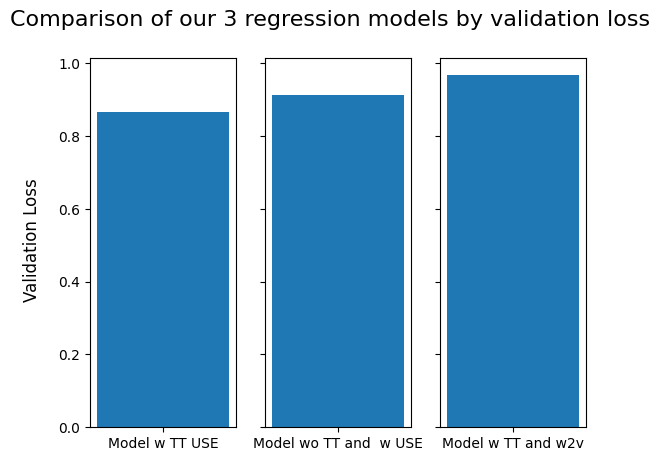

In [81]:
fig,ax=plt.subplots(1,3,sharey=True)

ax[0].bar(x=["Model w TT USE"],height=[historyhybridreg.history["val_loss"][-1]])
ax[1].bar(x=["Model wo TT and  w USE"],height=historyprereg.history["val_loss"][-1])
ax[2].bar(x=["Model w TT and w2v"],height=historyhybridreg2.history["val_loss"][-1])
fig.suptitle('Comparison of our 3 regression models by validation loss', fontsize=16)
fig.supylabel('Validation Loss')


In [ ]:
#Our regression model which has inputs USE and Task_Type are performed best by validation loss, so we will investigate this model more deeply

In [139]:
import math
import random

In [234]:
def roundielts(x):
  s=x%1
  if s>=0.25 and s<0.5:
    return math.floor(x)+0.5
  elif s<0.25:
    return math.floor(x)
  elif s>=0.5 and s>=0.75:
    return math.ceil(x)
  elif s>=0.5 and s<=0.75:
    return math.floor(x) + 0.5

In [131]:
X_test["indexes"]=X_test.index

In [137]:
X_test.reset_index(inplace=True)

In [225]:
def predictrandom(model):
  id=random.randint(0,len(X_test))
  pred=model.predict([pd.Series(X_test["Task_Type"][id]),pd.Series(X_test["text"][id])])
  pred2=roundielts(pred[0][0])
  print(f"Text\n{X_test.iloc[id]['text']}\nPrediction{pred2} Real:{y_test.iloc[id]}")


In [238]:
predictrandom(modelhybridreg)

1/1 [==============================] - 0s 22ms/step
Text
Following three pie chats depict the distribution of population globally compared to spending and consumption of resources by countries  Overall  we can obseve in the first figure that world spends more in food and transport  Whilst in second chart summerize population in the world with Asia has bigger share  However third figure notes that USA and Europe consume main resources of the world  By analysing following data  its evident that food have the bigger share of spending money including @ of total spending   Whilst transport comes next including @  housing and cloths consume @ and @ respectively   Nevertheless other aspects of life consume @   Meanwhile second pie chart about world population   Although Asia froms @ of population  highest percentage  Europe and America form @ distributed equally and Africa @    Interestingly USA and Europe consume @ of world resources and rest of the world consumes @   Clearly that USA and Eu

#Conclusion

In conclusion, We created neural network models with Task_Type,sentence and word embeddings. Creating classification models aren't sufficent for this problem as nearly all models are failed with 0.27 accuracy. However, after using regression models, we decreased the validation loss (mse) to 0.83 which is a very low number for these amount of data and the model predicts with 1 point deviation generally. Training this model with more data will decrease val_loss metrics more, and makes the model more useful. Thanks for reading.